### Notebook 2. Network with a hidden layer

Aim is to extend the model of notebook 1 to a neural network with one hidden layer. 
* The matricies $\mathbf{X}$, $\mathbf{\tilde{X}}$, $\mathbf{T}$ are generated as for the simple input-output network and $\mathbf{P}$ will denote the prediction matrix.
* The hidden layer has $n_h$ units as well as a bias. The matrix of its values for all samples is $\mathbf{H}$ with dimension $(n_s,n_h)$. An additional matrix $\mathbf{\tilde{H}}$ is defined that includes the bias as a column of ones, and has dimension $(n_s,n_h+1)$. 
* The matrix of weights $\mathbf{w}$ between layers $\tilde{X}$ and $H$ has dimensions $(3,n_h)$
* The matrix of weights $\mathbf{v}$ between layers $\tilde{H}$ and $P$ has dimensions $(n_h+1,1)$.
* The non-linearities are again given by sigmoidal activations of the linear input $z$ so that $f(z)=1/(1+\exp(-z))$. The prediction of the network can therefore be written in matrix form as
$$
f(\tilde{\mathbf{X}}\mathbf{w})=\mathbf{H}~~\mbox{ and} ~~f(\tilde{\mathbf{H}}\mathbf{v})=\mathbf{P}.
$$
* The cost function is the same as the previous case
$$C=-\frac{1}{n_s}\sum_s\left[T_s\log(P_s)+(1-T_s)\log(1-P_s)\right].$$

In [1]:
# libraries required for plotting and maths
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

### Q1 Generate the x,y data
* This time the data will not be separable by a straight line. 
* Consider two circles centred at (0.3,0.3) and (-0.5,0.5) both of radius 0.3.
* Generate $n_s=400$ points on the plane distributed as in the previous case.
* If the points fall within either circle they are assigned $t=1$, otherwise $t=0$.
* Generate the matricies $\mathbf{X}$ and $\mathbf{T}$ and plot out the scatter of data points.

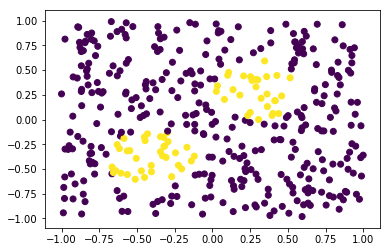

In [2]:
ns=400

# two circular blobs - requires more hidden layers to fit
cx1=0.3
cy1=0.3
r1=0.3

cx2=-0.4
cy2=-0.4
r2=0.3

# create the data
X=2*(np.random.rand(ns,2)-0.5)
C1=(X[:,0]-cx1)**2 + (X[:,1]-cy1)**2 < r1**2
C2=(X[:,0]-cx2)**2 + (X[:,1]-cy2)**2 < r2**2
T=1.0*(C1 | C2)
T=T[:,None]

# do the plots
plt.figure(figsize=(6,4))
plt.scatter(X[:,0],X[:,1],c=T);

### Q2 Write a function that calculates a prediction and cost for a given set of weights
* The input-to-output transformations are $$ f(\tilde{\mathbf{X}}\mathbf{w})=\mathbf{H}~~\mbox{ and} ~~f(\tilde{\mathbf{H}}\mathbf{v})=\mathbf{P}$$ 
where $f(z)=1/(1+e^{-z})$.
* The cost function is the same as before 
$$C=-\frac{1}{n_s}\sum_s\left[T_s\log(P_s)+(1-T_s)\log(1-P_s)\right]$$
* Creat a function that takes $\tilde{\mathbf{X}}$, $\mathbf{w}$, $\mathbf{v}$ and $\mathbf{T}$ as inputs, and then outputs the hidden layer $\mathbf{\tilde{H}}$, prediction matrix $\mathbf{P}$ and cost $C$.

In [3]:
def predict(Xb, w, v):
    assert Xb.shape[1]==w.shape[0]
    def sigmoid(z):
        return 1.0/(1+np.exp(-z))
    ns=Xb.shape[0]
    H=sigmoid(np.matmul(Xb,w))
    Hb=np.hstack([H, np.ones((ns,1))])
    P=sigmoid(np.matmul(Hb,v))
    return P, H

def cost(P, T):
    C = -np.sum(T*np.log(P)+(1-T)*np.log(1-P))/ns
    return C

### Q3 Write a function that calculates the weight gradients
* Using similar arguments to the simple input-output network show that
$$ \frac{dc}{dv_j}=\tilde{h}_j\delta^p~~~\mbox{ so that in matrix form}~~~ 
\frac{dC}{d\mathbf{v}}=\frac{1}{n_s}\tilde{\mathbf{H}}'\Delta^p
$$
is the gradient for the $\mathbf{v}$ weights, where $\delta^p=(p-t)$ and $\Delta^p_s$ is a matrix of dimension $(n_s,1)$. 
* Show that the cost gradient for $\mathbf{w}$ for a data point obeys
$$
\frac{dc}{dw_{ij}}=\frac{dc}{dp}\frac{dp}{dz^p}\frac{dz^p}{dh_j}\frac{dh_j}{dw_{ij}}=\tilde{x}_i\delta^h_j ~~~\mbox{ where }~~~\delta_j^h=h_j(1-h_j)\delta^pv_j~~~\mbox{ and $j$ runs from 1 to $n_h$}
$$
* This gives the gradient for the $\mathbf{w}$ weights as
$$
\frac{dC}{d\mathbf{w}}=\frac{1}{n_s}\tilde{\mathbf{X}}'\Delta^h
$$
where the $(n_s,n_h)$ dimensional matrix $\Delta^h$ has entries that are
$$
\Delta^h_{sj}=H_{sj}(1-H_{sj})[\Delta_s^pv_j]
$$
* Write a function that takes in $\mathbf{\tilde{X}}$, $\mathbf{\tilde{H}}$, $\mathbf{v}$, $\mathbf{P}$ and $\mathbf{T}$ and outputs $dC/d\mathbf{w}$ and $dC/d\mathbf{v}$.

In [4]:
def gradient(Xb, Hb, v, P, T):
    assert P.shape==T.shape
    ns=Xb.shape[0]
    Δp=P-T
    dCdv=np.matmul(Hb.T, Δp)/ns
    
    M=np.matmul(Δp,v[:-1].T)
    Δh=Hb[:,:-1]*(1-Hb[:,:-1])*M
    dCdw=np.matmul(Xb.T,Δh)/ns
    return dCdw, dCdv

### Q4 Gradient descent for the weights
* Write a loop that does $n$ iterations of the gradient descent, where for each one the weight matricies are updated 
$$ \mathbf{w}_\mathrm{new}=\mathbf{w}_\mathrm{old}-\alpha\frac{dC}{d\mathbf{w}} 
~~~\mbox{ and }~~~
\mathbf{v}_\mathrm{new}=\mathbf{v}_\mathrm{old}-\alpha\frac{dC}{d\mathbf{v}} 
$$ where $\alpha$ is a positive learning rate that you can choose.
* Plot a graph of the cost $C$ as a function of the iteration steps and check that it is monotonically decreasing.
* How does the cost vary with different choices of $n_h$?
* What is the percentage of correctly classified data points in each case?

In [5]:
def GradDescent(X, T, nh, α, n_iter):
    
    n_samples=X.shape[0]
    nx=X.shape[1]
    Xb=np.hstack([X,np.ones((n_samples,1))])
    w=np.random.randn(nx+1,nh)
    v=np.random.randn(nh+1,1)
    
    C_i=np.zeros((n_iter,1))
    
    for i in range(n_iter):
        P, H = predict(Xb, w, v)
        Hb=np.hstack([H,np.ones((n_samples,1))])
        C_i[i] = cost(P, T)
        dCdw, dCdv = gradient(Xb, Hb, v, P, T)
        w=w-α*dCdw
        v=v-α*dCdv
        
    return (w, v, C_i)

In [6]:
nh=10
α=2
ni=10000
w,v,Ci = GradDescent(X,T,nh,α,ni)

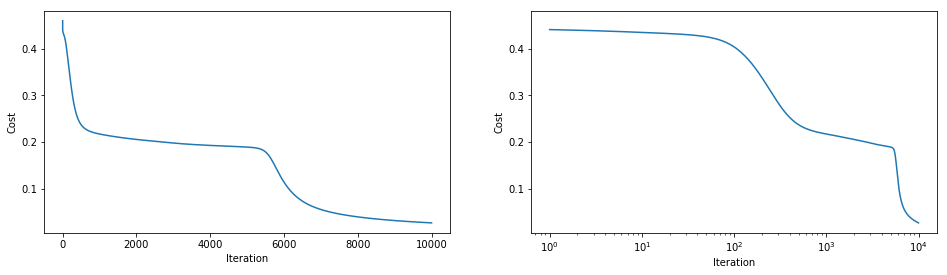

In [7]:
plt.figure(figsize=(16,9))
plt.subplot(221)
plt.plot(np.arange(Ci.shape[0]), Ci)
plt.xlabel('Iteration')
plt.ylabel('Cost')

plt.subplot(222)
plt.semilogx(np.arange(Ci.shape[0]), Ci)
plt.xlabel('Iteration')
plt.ylabel('Cost');

In [8]:
Xb = np.hstack([X, np.ones((ns,1))])
predictions, hidden = predict(Xb, w, v)
accuracy = np.sum(1*(predictions>0.5)==T)/ns
print("Percetage of correctly classified datapoints:", "{}%".format(100*accuracy))

Percetage of correctly classified datapoints: 99.75%


### Q5 Plotting the classifier and hidden layers

This data is not linearly separable; however, you can interpret the weights coming into the hidden layer as defining $n_h$ lines, like was done for the simple input-output case in notebook 1. 
* Plot the $n_h$ lines represented by the weight matrix $\mathbf{w}$ to gain insight into the role of the hidden layer.
* Plot a grid of points on the plane that are colour coded by the predictions. This can be achieved by using one of the previous functions. 

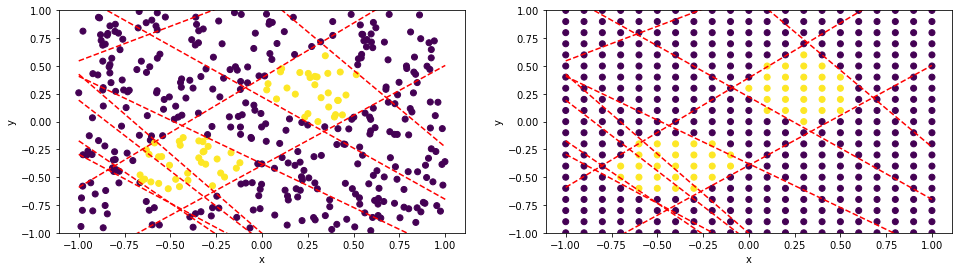

In [9]:
x = np.linspace(-1,1,100)

y2 = []
for i in range(w.shape[1]):
    y2.append(-x*w[0,i]/w[1,i]-w[2,i]/w[1,i])

plt.figure(figsize=(16,9))
    
plt.subplot(221)
plt.scatter(X[:,0],X[:,1],c=T)
for yy in y2:
    plt.plot(x,yy,'r--')
plt.ylim((-1,1))
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(222)
axis=np.arange(-1,1.1,0.1)
xx, yy =np.meshgrid(axis, axis)
xx = np.matrix.flatten(xx)[:,None]
yy = np.matrix.flatten(yy)[:,None]
XXb = np.hstack([xx,yy,np.ones_like(xx)])
PP, _ = predict(XXb, w, v)
PP = (PP>0.5)
plt.scatter(xx, yy, c=PP)
for yy in y2:
    plt.plot(x,yy,'r--')
plt.ylim((-1,1))
plt.xlabel('x')
plt.ylabel('y');

### Q6 Comparison with a test set of data
An additional question if you have time.
* Generate a test set of data and compare the classification of the already trained network with those data.
* How do the percentages of training (first set) and test set vary as you increase the number of hidden units?